In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks/house-prices-advanced-regression-techniques

/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques


## import

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_train = pd.read_csv('data/train_final.csv')

In [5]:
X = df_train.drop(['SalePrice','SalePrice_log'], axis=1)
y = df_train['SalePrice_log']

## train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Scale the data

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## model

### one time call functions

In [10]:
#performance = pd.DataFrame(columns=['model','rmse_test','rmse_train','r2_test','r2_train'])
performance = pd.read_csv('data/performance.csv')

In [11]:
def run_model(model, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, save=False, fit=True, model_name=None):
    if model_name is None:
        model_name = model.__class__.__name__

    if fit:
        model.fit(X_train, y_train)


    rmse_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    r2_test = r2_score(y_test, model.predict(X_test))
    r2_train = r2_score(y_train, model.predict(X_train))


    if save:
        performance.loc[len(performance)] = [model_name, rmse_test, rmse_train, r2_test, r2_train]

    print(f'{model_name} test RMSE: {rmse_test} train RMSE: {rmse_train}')


def run_grid_search(model, param_grid, X_train=X_train_scaled, X_test=X_test_scaled, y_train=y_train, y_test=y_test, save=False,model_name=None, **kwargs):
    if model_name is None:
        model_name = model.__class__.__name__

    warnings.filterwarnings('ignore')
    gs = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', **kwargs,verbose=1)
    gs.fit(X_train, y_train)

    
    rmse_test = np.sqrt(mean_squared_error(y_test, gs.predict(X_test)))
    rmse_train = np.sqrt(mean_squared_error(y_train, gs.predict(X_train)))
    r2_test = r2_score(y_test, gs.predict(X_test))
    r2_train = r2_score(y_train, gs.predict(X_train))

    if save:
        performance.loc[len(performance)] = [model_name, rmse_test, rmse_train, r2_test, r2_train]

    
    #send_notification(f'{model_name} test RMSE: {rmse_test} train RMSE: {rmse_train}')

    print(f'{model_name} test RMSE: {rmse_test} train RMSE: {rmse_train}', gs.best_params_)
    return gs


#def send_notification(message='Task Completed'):
    #subprocess.run(['notify-send' ,message])

### Linear Regression

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lr_base = LinearRegression()

In [14]:
run_model(lr_base, save=True, fit=True, model_name='LinearRegression Initial')

LinearRegression Initial test RMSE: 0.11226451994031916 train RMSE: 0.10181444153666112


In [15]:
performance.to_csv('data/performance.csv', index=False)

- let's try to impose some regularization on the model

## Elastic Net

In [16]:
from sklearn.linear_model import ElasticNet

In [17]:
enet_base = ElasticNet(random_state=42)

In [18]:
run_model(enet_base, save=True, fit=True, model_name='ElasticNet Initial')

ElasticNet Initial test RMSE: 0.3853372362643226 train RMSE: 0.3989001395404213


- this is not performing good let's try Grid Search

### Grid Search

In [19]:
enet_grid_base = ElasticNet(random_state=42)

In [20]:
param_grid = {
    'alpha': [0.0, 0.001, 0.01, 0.1, 0.5, 0.9, 1.0],
    'l1_ratio': [0.0, 0.001, 0.01, 0.1, 0.5, 0.9, 1.0]
}

In [21]:
grid_1 = run_grid_search(enet_grid_base, param_grid, model_name='ElasticNet Grid Search')

Fitting 5 folds for each of 49 candidates, totalling 245 fits
ElasticNet Grid Search test RMSE: 0.11208517985091458 train RMSE: 0.10191321202363049 {'alpha': 0.001, 'l1_ratio': 0.1}


- let's try to narrow down the search

In [22]:
param_grid = {
    'alpha': [0.0008, 0.001, 0.003, 0.006],
    'l1_ratio': [0.08, 0.1, 0.3, 0.6]
}

In [23]:
grid_2 = run_grid_search(enet_grid_base, param_grid, model_name='ElasticNet Grid Search')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
ElasticNet Grid Search test RMSE: 0.11194448111548021 train RMSE: 0.10211431107101998 {'alpha': 0.0008, 'l1_ratio': 0.3}


- let's try to tune alpha, as only in that there is change

In [24]:
param_grid = {
    'alpha': [0.0006, 0.0007, 0.0008, 0.0009],
    'l1_ratio': [0.09, 0.1, 0.2]
}

In [25]:
grid_3 = run_grid_search(enet_grid_base, param_grid, model_name='ElasticNet Grid Search')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
ElasticNet Grid Search test RMSE: 0.1119892770962123 train RMSE: 0.1020133454986297 {'alpha': 0.0009, 'l1_ratio': 0.2}


- as there is not much improvement in the error, we will save this data for later use

In [26]:
run_model(grid_3.best_estimator_, save=True, fit=False, model_name='ElasticNet Grid Search')

ElasticNet Grid Search test RMSE: 0.1119892770962123 train RMSE: 0.1020133454986297


In [27]:
performance.to_csv('data/performance.csv', index=False)

## KNears Neighbours

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
knn_base = KNeighborsRegressor()

In [30]:
run_model(knn_base, save=True, fit=True, model_name='KNeighborsRegressor Initial')

KNeighborsRegressor Initial test RMSE: 0.1830760068597592 train RMSE: 0.1479863048671326


- let's try to find the best k value

In [31]:
def find_k(k_max):
    error = []
    for k in range(1,k_max):
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        error.append(np.sqrt(mean_squared_error(y_test, knn.predict(X_test))))
    return error
    

In [32]:
k_val = find_k(20)

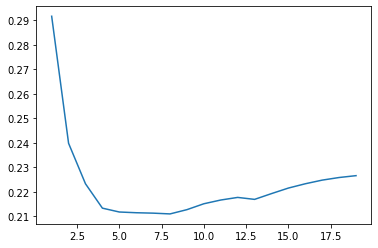

In [33]:
plt.plot(range(1,len(k_val)+1), k_val);

- it look like that default n_neighbors is 5, which is good,
- we will not perform grid search in this as it is not giving a good result

In [34]:
performance.to_csv('data/performance.csv', index=False)

## Decision Tree Regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor

In [36]:
dt_base = DecisionTreeRegressor(random_state=42)

In [37]:
run_model(dt_base, save=True, fit=True, model_name='DecisionTreeRegressor Initial')

DecisionTreeRegressor Initial test RMSE: 0.20175632718247027 train RMSE: 0.0


- this is badly overfitting, let's try to find the best parameters

### Grid Search

In [38]:
df_grid_base = DecisionTreeRegressor(random_state=42)

In [39]:
param_grid = {
    'criterion': ['mse', 'friedman_mse', 'mae','squared_eror'],
    'splitter': ['best', 'random'],
    'max_depth': [3,6],
    'min_samples_split': [2,4],
}

In [40]:
grid_1 = run_grid_search(df_grid_base, param_grid, model_name='DecisionTreeRegressor Grid Search')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
DecisionTreeRegressor Grid Search test RMSE: 0.18809982555231128 train RMSE: 0.12653592092204333 {'criterion': 'mse', 'max_depth': 6, 'min_samples_split': 4, 'splitter': 'best'}


- it's better but still Linear Regression is better than Decision Tree Regressor, let's save it and try another model

In [41]:
run_model(grid_1.best_estimator_, save=True, fit=False, model_name='DecisionTreeRegressor Grid Search')

DecisionTreeRegressor Grid Search test RMSE: 0.18809982555231128 train RMSE: 0.12653592092204333


In [42]:
performance.to_csv('data/performance.csv', index=False)

## Random Forest Regressor

In [43]:
from sklearn.ensemble import RandomForestRegressor

In [44]:
rfg_base = RandomForestRegressor(random_state=42)

In [45]:
run_model(rfg_base, save=True, fit=True, model_name='RandomForestRegressor Initial')

RandomForestRegressor Initial test RMSE: 0.132526180778473 train RMSE: 0.05137585998591226


- let's try to tune the best hyperparameters using grid search

### Grid Search

In [46]:
rfg_grid_base = RandomForestRegressor(random_state=42)

In [47]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3,6],
    'min_samples_split': [2,4],
}

In [48]:
grid_1 = run_grid_search(rfg_grid_base, param_grid, model_name='RandomForestRegressor Grid Search')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForestRegressor Grid Search test RMSE: 0.14093583487754494 train RMSE: 0.10185461934028973 {'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 400}


- let's narrow down the search

In [49]:
param_grid = {
    'n_estimators': [400],
    'max_depth': [5,6,7],
    'min_samples_split': [3,4,5],
}

In [50]:
grid_2 = run_grid_search(rfg_grid_base, param_grid, model_name='RandomForestRegressor Grid Search')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
RandomForestRegressor Grid Search test RMSE: 0.1362532227563184 train RMSE: 0.08716223501117258 {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 400}


- there is not much improvement in the error, but the model got overfitted hence saving the previous grid search data

In [51]:
run_model(grid_1.best_estimator_, save=True, fit=False, model_name='RandomForestRegressor Grid Search')

RandomForestRegressor Grid Search test RMSE: 0.14093583487754494 train RMSE: 0.10185461934028973


In [52]:
performance.to_csv('data/performance.csv', index=False)

## XGBoost Regressor

In [53]:
from xgboost import XGBRegressor

In [54]:
xgb_base = XGBRegressor(random_state=42)

In [55]:
run_model(xgb_base, save=True, fit=True, model_name='XGBRegressor Initial')

[07:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor Initial test RMSE: 0.1260283737880103 train RMSE: 0.08591171739136046


- try to find the n_estimators by elbow method

In [56]:
def find_n_estimator(n_max):
    error = []
    error_train = []
    for n in range(100,n_max,100):
        xgb = XGBRegressor(n_estimators=n, random_state=101,n_jobs=-1)
        xgb.fit(X_train, y_train)
        error.append(np.sqrt(mean_squared_error(y_test, xgb.predict(X_test))))
        error_train.append(np.sqrt(mean_squared_error(y_train, xgb.predict(X_train))))
    return error,error_train

In [57]:
error_test,error_train = find_n_estimator(800)

[07:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:15:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


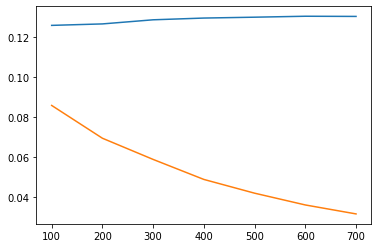

In [58]:
plt.plot(range(100,800,100), error_test);
plt.plot(range(100,800,100), error_train);

- this shows that n_estimators = 100 is best, which is default value

- et's try to find the other best parameters

### Grid Search

In [59]:
xgb_base.get_params

<bound method XGBModel.get_params of XGBRegressor(random_state=42)>

In [73]:
xgb_grid_base = XGBRegressor(random_state=42)

In [74]:
param_grid = {'max_depth': [3,6,7],
                'learning_rate': [ 0.01, 0.1,  1],
                'min_child_weight': [1, 5, 9],
                'gamma': [0, 0.01, 0.1, 0.9, 1],
              'objective': ["reg:squarederror"]
}

In [75]:
grid_1 = run_grid_search(xgb_grid_base, param_grid, model_name='XGBRegressor Grid Search')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
XGBRegressor Grid Search test RMSE: 0.12232012145092339 train RMSE: 0.05199605390266689 {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'objective': 'reg:squarederror'}


- let's try to do more narrow search

In [76]:
param_grid = {'max_depth': [5,6],
                'learning_rate': [ 0.08, 0.1,  0.2],
                'min_child_weight': [4,5,6],
                'gamma': [0, 0.001, 0.003],
              'objective': ["reg:squarederror"] 
}

In [77]:
grid_2 = run_grid_search(xgb_grid_base, param_grid, model_name='XGBRegressor Grid Search');

Fitting 5 folds for each of 54 candidates, totalling 270 fits
XGBRegressor Grid Search test RMSE: 0.12232012145092339 train RMSE: 0.05199605390266689 {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'objective': 'reg:squarederror'}


- as there is no further improvement, hence saving this result

In [78]:
run_model(grid_2.best_estimator_, save=True, fit=False, model_name='DecisionTreeRegressor Grid Search')

DecisionTreeRegressor Grid Search test RMSE: 0.12232012145092339 train RMSE: 0.05199605390266689


In [79]:
performance.to_csv('data/performance.csv', index=False)

## Voting Regressor

- let's try to make a ensemble of the best models

In [80]:
from sklearn.ensemble import VotingRegressor

In [81]:
performance

,model,rmse_test,rmse_train,r2_test,r2_train
0,LinearRegression Initial,0.112265,0.101814,0.914957,0.934854
1,ElasticNet Initial,0.385337,0.398900,-0.001926,0.000000
2,ElasticNet Grid Search,0.111989,0.102013,0.915373,0.934599
3,KNeighborsRegressor Initial,0.183076,0.147986,0.773840,0.862370
4,DecisionTreeRegressor Initial,0.201756,0.000000,0.725332,1.000000
5,DecisionTreeRegressor Grid Search,0.188100,0.126536,0.761257,0.899377
6,RandomForestRegressor Initial,0.132526,0.051376,0.881489,0.983412
7,RandomForestRegressor Grid Search,0.140936,0.101855,0.865972,0.934802
8,XGBRegressor Initial,0.126028,0.085912,0.892826,0.953615
9,DecisionTreeRegressor Grid Search,0.122320,0.051996,0.899040,0.983009


In [86]:
lr = LinearRegression()
els = ElasticNet( alpha = 0.0009, l1_ratio= 0.2 )
xgb = XGBRegressor( gamma= 0, learning_rate = 0.1, max_depth= 6, min_child_weight= 5, objective= 'reg:squarederror' )

In [113]:
vr_base = VotingRegressor( estimators=[('lr', lr), ('els', els), ('xgb',xgb)], weights=[1.7,1.4,1] )

In [114]:
run_model(vr_base, save=False)

VotingRegressor test RMSE: 0.10984943334814566 train RMSE: 0.08688619649966439


## Final Model

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [129]:
final_X = pd.read_csv('data/test_final.csv')

In [130]:
X_scaled = scaler.fit_transform(X)

x_to_pre = scaler.transform(final_X)

In [131]:
lr = LinearRegression()
els = ElasticNet( alpha = 0.0009, l1_ratio= 0.2 )
xgb = XGBRegressor( gamma= 0, learning_rate = 0.1, max_depth= 6, min_child_weight= 5, objective= 'reg:squarederror' )

In [132]:
from sklearn.ensemble import VotingRegressor
final_model = VotingRegressor( estimators=[('lr', lr), ('els', els), ('xgb',xgb)], weights=[1.7,1.4,1] )

In [133]:
final_model.fit(X_scaled,y)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('els', ElasticNet(alpha=0.0009, l1_ratio=0.2)),
                            ('xgb',
                             XGBRegressor(max_depth=6, min_child_weight=5,
                                          objective='reg:squarederror'))],
                weights=[1.7, 1.4, 1])

In [134]:
y_pre = final_model.predict(x_to_pre)

In [135]:
sale_price = np.exp(y_pre)

In [139]:
sale_price  =  np.round(sale_price,-2)

In [145]:
id = np.arange(1461,2920)

In [152]:
id.reshape(1,-1)

array([[1461, 1462, 1463, ..., 2917, 2918, 2919]])

In [160]:
sale_price

array([124200., 161900., 180900., ..., 154300., 116200., 223700.])

In [163]:
df = pd.DataFrame((id, sale_price)).transpose()

In [169]:
df.columns = ['Id','SalePrice']

In [170]:
df['Id'] = df['Id'].astype(int)

In [171]:
df.head()

,Id,SalePrice
0,1461,124200.0
1,1462,161900.0
2,1463,180900.0
3,1464,192800.0
4,1465,201400.0


In [173]:
df.to_csv('submit.csv',index=False)